## Second draft of Contrast algorithm

## To do

## Not to do
- Inverse law when seeing duplicates
- Implement context

## Done
- ✔ Refactor everything so they use the good memories (object or contrast):
currently, only feed_data_online has been updated
- ✔ Forgetting data
- ✔ Compute standard_distances for each cluster
- ✔ Clustering validity checking methods (Note: not necessarily relevant
  though)

## Imports

In [1]:
# import time
# import csv
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import pandas as pd
# from scipy.stats import chi2
from scipy.stats import special_ortho_group
# from scipy.spatial.distance import mahalanobis
# from sklearn import metrics
from utils import plot_confusion_matrix
import collections
import functools
import itertools
# from sklearn.utils.multiclass import unique_labels

np.random.seed(1)

## Global variables and functions

In [2]:
# --- Information for generating dataset ---
NB_FEATURES = 5
NB_GROUPS = 5
N = 300
DOMAIN_LENGTH = 200
DEV_MAX = 20

COLORS = ['r', 'g', 'b', 'y', 'c', 'm']

# stocks metadata as (DATASET_NAME, DATASET_EXTENSION, DATASET_PATH,
#     \ DATASET_CLUSTER_COLUMN_INDEX, DATASET_DATA_COLUMNS_INDICES)
METADATA = {
    'Cards': ('Cards', '.csv', 'data/', 1, (2, None)),
    'Cards_truncated': ('Cards', '.csv', 'data/', 1, (2, 7))
}

SHOULD_LOAD_DATASET = 2  # 0 to generate, 1 to load csv, 2 to load sklearn

if SHOULD_LOAD_DATASET == 1:
    NAME = 'Cards'
    DATASET_NAME, DATASET_EXTENSION, DATASET_PATH, \
        DATASET_CLUSTER_COLUMN_INDEX, \
        DATASET_DATA_COLUMNS_INDICES = METADATA[NAME]
    DATASET_PATH_FULL = DATASET_PATH + DATASET_NAME + DATASET_EXTENSION
elif SHOULD_LOAD_DATASET == 0:
    DATASET_PATH = 'data/'
    DATASET_NAME = 'dummy'
elif SHOULD_LOAD_DATASET == 2:
    from sklearn.datasets import load_iris
    load_dataset = load_iris
    DATASET_PATH = 'data/'
    DATASET_NAME = 'iris'

PRINT_METRICS_DEFINED = False


def generate_cluster(n_cluster, nb_features=NB_FEATURES, d=DOMAIN_LENGTH,
                     dev_max=DEV_MAX, method='byhand'):
    """
    The 'method' argument can be one of the following:
    - 'byhand'
    - 'multinormal'
    """
    mean = np.random.random(nb_features) * d
    if method == 'multinormal':
        # /!\ does not work: data does not seem random at all, covariance is
        # always positive...!
        raise DeprecationWarning("beware, 'multinormal' method does not seem"
                                 "to work")
        cov = np.tril(np.random.random((nb_features, n_cluster)) *
                      np.random.random() * dev_max)
        cov = cov @ cov.transpose()  # a covariance matrix
        return(np.random.multivariate_normal(mean, cov, n_cluster))
    else:
        if method != 'byhand':
            print("generate_cluster: method unknown, using 'byhand'")
        st_devs = dev_max * np.random.random(nb_features)
        # holds the st_devs of each feature
        cluster_points = np.zeros((n_cluster, nb_features))
        for i in range(n_cluster):
            for j in range(nb_features):
                cluster_points[i][j] = np.random.normal(loc=mean[j],
                                                        scale=st_devs[j])
        cluster_points = cluster_points @ special_ortho_group.rvs(nb_features)
        return(cluster_points)


def generate_dataset(nb_groups=NB_GROUPS, n=N, nb_features=NB_FEATURES,
                     d=DOMAIN_LENGTH, dev_max=DEV_MAX):
    group_sizes = np.random.random(nb_groups)
    group_sizes *= n / np.sum(group_sizes)
    group_sizes = np.trim_zeros(np.round(group_sizes)).astype(int)
    data = [generate_cluster(n_cluster) for n_cluster in group_sizes]
    data = np.vstack(data)
    clusters_true = np.concatenate([n_cluster * [i] for i, n_cluster in
                                    enumerate(group_sizes)])
    np.save(DATASET_PATH + DATASET_NAME + '_data.npy', data)
    np.save(DATASET_PATH + DATASET_NAME + '_clusters_true.npy', clusters_true)


def shuffle(data_to_shuffle):
    new_permutation = np.random.permutation(len(data_to_shuffle))
    return(data_to_shuffle[new_permutation])

## Generate or load dataset

In [3]:
if SHOULD_LOAD_DATASET == 0:
    generate_dataset()
    data = np.load(DATASET_PATH + DATASET_NAME + '_data.npy')
    clusters_true = np.load(DATASET_PATH + DATASET_NAME +
                            '_clusters_true.npy').astype(int)
elif SHOULD_LOAD_DATASET == 1:
    start, end = DATASET_DATA_COLUMNS_INDICES
    df1 = pd.read_csv(DATASET_PATH_FULL)
    df1_np = df1.to_numpy(copy=True)
    data = df1_np[:, start:end].astype('float')
    clusters_true = df1_np[:, DATASET_CLUSTER_COLUMN_INDEX]
elif SHOULD_LOAD_DATASET == 2:
    dataset = load_dataset()
    data = dataset["data"]
    clusters_true = dataset["target"]


assert data is not None, 'data is None'
assert clusters_true is not None, 'clusters_true is None'

# clusters_true2 will contain ids instead of labels
ids = collections.defaultdict(functools.partial(next,
                                                itertools.count()))
clusters_true2 = np.array([ids[label] for label in clusters_true])
nb_clusters_true = np.max(clusters_true2) + 1

# print(data)
# print(clusters_true)

## Preview dataset

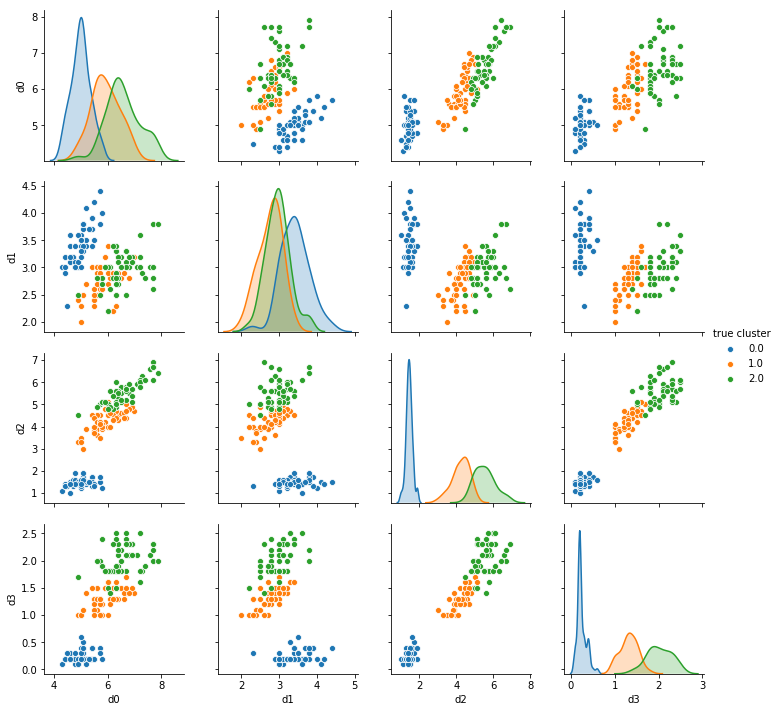

In [4]:
columns = ["d" + str(i) for i in range(data.shape[1])] + ['true cluster']
df = pd.DataFrame(np.hstack((data, np.reshape([clusters_true],
                                              (data.shape[0], 1)))),
                  columns=columns)
true_data_plot = sns.pairplot(df, kind="scatter", hue='true cluster',
                              vars=columns[:-1])
true_data_plot.savefig(DATASET_PATH + DATASET_NAME + '_true.png')

## The agent

In [5]:
class ContrastAgent(object):
    def __init__(self,
                 cmemory_size=50,
                 eps=0.01,
                 maxi=2.5,
                 memory_size=50,
                 mini=1,
                 nb_closest=8,
                 nb_winners=1,
                 update_method=2):

        self.deviations = {1: [], 2: []}
        self.eps = eps
        self.maxi = maxi
        self.memories = {1: [], 2: []}
        self.memory_sizes = {1: memory_size, 2: cmemory_size}
        self.mini = mini
        self.nb_closest = nb_closest
        self.nb_winners = nb_winners
        self.update_method = update_method
        self.weights = {1: [], 2: []}

    def adjusted_threshold(self, x, maxi, mini, a=0.2, b=5):
        """ https://www.desmos.com/calculator/rydyha6kmb """
        return (maxi - ((maxi - mini) / (1 + np.exp(-(a*(x-1) - b)))))

    def cluster_battles(self, obj, indices, data_order, nb_winners=1):
        winner_indices = []
        while len(indices) > nb_winners:
            if len(indices) % 2 == 1:
                winner_indices.append(indices.pop(
                    np.random.randint(len(indices))))
            for i in range(0, len(indices), 2):
                dim_a, dim_b = 0, 0
                a = indices[i]
                b = indices[i+1]
                for j in range(len(obj)):
                    if np.abs(self.memories[data_order][a][j] - obj[j]) > \
                            np.abs(self.memories[data_order][b][j] - obj[j]):
                        dim_a += 1
                    else:
                        dim_b += 1
                if dim_a > dim_b:
                    winner_indices.append(a)
                else:
                    winner_indices.append(b)
            indices = winner_indices
            winner_indices = []
        return indices

    def extract_contrasts(self, obj, contrast_indices, data_order):
        contrasts = []
        for i in contrast_indices:
            new_contrast = np.zeros(len(obj))
            for j in range(len(obj)):
                if not self.is_in_cluster_dimension(obj, i, j, data_order, tolerance=1):
                    new_contrast[j] = np.abs(obj[j] - self.memories[data_order][i][j])
            if np.any(new_contrast):  # if new_contrasts is not zero
                contrasts.append(new_contrast)
        return np.array(contrasts)
    
    def feed_data_online(self, new_data, data_order):
        is_empty = len(self.memories[data_order]) == 0
        if is_empty:
            self.update_clusters(new_data[0], data_order)
        for obj in new_data[is_empty:]:
            nb_winners = self.nb_winners
            if data_order == 2:
                nb_winners = 1
            # find_cluster updates clusters
            nb = len(self.find_cluster(
                obj, data_order,
                update=True, nb_winners=nb_winners))
            if data_order == 1:
#                 new_contrasts = np.abs(self.memories[data_order][-(nb+1):-1] - obj)
                new_contrasts = self.extract_contrasts(obj, list(range(-(nb+1),-1)), data_order)
                if len(new_contrasts) > 0:
                    self.feed_data_online(new_contrasts, data_order=2)

    def find_cluster(self, obj, data_order, update=True, nb_winners=1):
        n_closest_indices = self.find_n_closest_prototypes(obj,
                                                           data_order,
                                                           n=self.nb_closest)
        winner_indices = self.cluster_battles(obj, n_closest_indices,
                                              data_order,
                                              nb_winners=nb_winners)
        if update:
            self.update_clusters(obj, data_order, winner_indices,
                                 method=self.update_method)
        return winner_indices

    def find_n_closest_prototypes(self, obj, data_order, n=4):
        matching_dims = np.zeros(len(self.memories[data_order]))
        for i in range(len(self.memories[data_order])):
            for j in range(len(obj)):
                if self.is_in_cluster_dimension(obj, i, j, data_order):
                    matching_dims[i] += 1
#         unique_dims = np.unique(matching_dims)
#         closest_indices = np.concatenate(
#             [np.flatnonzero(matching_dims == i) for i in unique_dims])
        max_dims = np.max(matching_dims)
#         print("max_dims: {}".format(max_dims))
        closest_indices = \
            np.flatnonzero(matching_dims == max_dims)
        # print("closest_indices: {}".format(closest_indices))
        if len(closest_indices) > n:
            # closest_indices = np.random.choice(closest_indices, 4,
            #                                    replace=False)
            closest_indices = closest_indices[-n:]
        return closest_indices.tolist()

    def forget_if_needed(self, data_order):
        while len(self.memories[data_order]) > self.memory_sizes[data_order]:
            self.memories[data_order].pop(0)
            self.weights[data_order].pop(0)
            self.deviations[data_order].pop(0)

    def is_in_cluster_dimension(self, obj, i, j, data_order, tolerance=1):
        return np.abs(obj[j] - self.memories[data_order][i][j]) <= \
            self.deviations[data_order][i][j] * \
            self.adjusted_threshold(self.weights[data_order][i],
                                    self.maxi, self.mini) * \
            tolerance

    def update_clusters(self, obj, data_order,
                        winner_indices=None, method=2):
        """
            method 1: weighted averaged standard deviations
            method 2: weighted averaged distances
        """
        
        if winner_indices is not None:

            for cluster_index in winner_indices:
                old_weight = self.weights[data_order].pop(cluster_index)
                old_deviations = self.deviations[data_order].pop(cluster_index)
                old_prototype = self.memories[data_order].pop(cluster_index)

                new_weight = old_weight + 1
                if method == 1:
                    temp = np.repeat(np.array([old_prototype, obj]),
                                     [old_weight, 1],
                                     axis=0)
                    deviation_with_obj = np.std(temp, axis=0)
                    new_deviations = (old_deviations * old_weight +
                                      deviation_with_obj) / new_weight
                else:
                    if method != 2:
                        print("update_clusters: "
                              "unknown method, using method 2")
                    new_deviations = (old_deviations * old_weight +
                                      np.abs(old_prototype - obj)) / new_weight

                new_prototype = (old_weight * old_prototype + obj) / new_weight

                self.weights[data_order].append(new_weight)
                self.deviations[data_order].append(new_deviations)
                self.memories[data_order].append(new_prototype)

        self.weights[data_order].append(1)
        self.deviations[data_order].append(np.abs(self.eps * obj))
        self.memories[data_order].append(obj)

        self.forget_if_needed(data_order)

    # --- Plot functions ---

    def print_confusion_matrix(self, data, clusters_true,
                               cmap=plt.cm.Blues,
                               cmap2=plt.cm.Reds,
                               method="closest",
                               nb_winners=4,
                               tolerance=2.5):
        """
            method can be either "all" or "closest"
        """
        data_order = 1
        nb_clusters_true = np.max(clusters_true) + 1
        cluster_true_sizes = [np.count_nonzero(clusters_true == i) for i in
                              range(nb_clusters_true)]
        cm = np.zeros((len(self.memories[data_order]), nb_clusters_true))

        if method == "all":
            for obj_i, obj in enumerate(data):
                for i in range(len(self.memories[data_order])):
                    if all([self.is_in_cluster_dimension(
                                obj, i, j, data_order, tolerance=tolerance) \
                            for j in range(len(obj))]):
                        cm[i][clusters_true[obj_i]] += 1
        else:
            if method != "closest":
                print("print_confusion_matrix: unknown"
                      "is_in_cluster_method, using 'closest'")
            for obj_i, obj in enumerate(data):
                winner_indices = self.find_cluster(obj, data_order, update=False, nb_winners=nb_winners)
                for i in winner_indices:
                    cm[i][clusters_true[obj_i]] += 1

        cm /= cluster_true_sizes

        # print(cm)

        title = 'Normalized confusion matrix'
        fig, (ax1, ax2) = plt.subplots(
                              1, 2, sharey=True,
                              figsize=(4+nb_clusters_true, 4+len(self.memories[data_order])/5)
                              )
        im1 = ax1.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
        ax1.figure.colorbar(im1, ax=ax1)
        # We want to show all ticks...
        ax1.set(xticks=np.arange(cm.shape[1]),
                yticks=np.arange(cm.shape[0]),
                # ... and label them with the respective list entries
                xticklabels=np.arange(cm.shape[1]),
                yticklabels=np.arange(cm.shape[0]),
                title=title,
                ylabel='Predicted label',
                xlabel='True label')

        im2 = ax2.imshow(np.reshape(self.weights[data_order], (-1, 1)),
                         interpolation='nearest',
                         cmap=cmap2)
        ax2.figure.colorbar(im2, ax=ax2)
        ax2.set(xticks=np.arange(0),
                yticks=np.arange(len(self.weights[data_order])),
                yticklabels=np.arange(len(self.weights[data_order])),
                title="Weights")

        # Rotate the tick labels and set their alignment.
        # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        #          rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f'
        fmt2 = 'd'
        thresh = cm.max() / 2.
        thresh2 = np.max(self.weights[data_order]) / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax1.text(j, i, format(cm[i, j], fmt),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
            ax2.text(0, i, format(self.weights[data_order][i], fmt2),
                     ha="center", va="center",
                     color="white" if self.weights[data_order][i] > thresh2 else "black")
        fig.tight_layout()
        plt.savefig(DATASET_PATH + DATASET_NAME + '_confusion_matrix.png')
        return fig
    
    def print_contrasts(self, nb_print=10, data_order=2):
        if nb_print > self.memory_sizes[data_order]:
            nb_print = self.memory_sizes[data_order]
        memory = ca.memories[2][-nb_print:]
        n_dim = data.shape[1]+1
        fig, axes = plt.subplots(n_dim, 1, figsize=(nb_print, n_dim+5), sharex=True)
        x = np.arange(nb_print)
        mem = np.array(memory)
        for i, ax in enumerate(axes):
            if i == n_dim-1:
                sns.barplot(x=x, y=self.weights[2][-nb_print:], ax=ax)
                ax.set(title="Weights")
            else:
                sns.barplot(x=x, y=mem[:,i], ax=ax)
        fig.tight_layout()

## Data manipulation

In [6]:
new_data = np.copy(data)


def data_add(j, x):
    new_data[:, j] += x


def data_mult(j, x):
    new_data[:, j] *= x


def data_func(j, f):
    new_data[:, j] = f(new_data[:, j])


MANIPULATION_ROUNDS = 0

def manipulate_data(rounds):
    for i in range(rounds):
        manip = np.random.randint(2)
        j = np.random.randint(new_data.shape[1])
        x = (2 * np.random.random() - 1) * 10**np.random.randint(-8, 8)
        if manip == 0:
            data_add(j, x)
            print("Column {}: added {}".format(j, x))
        else:
            data_mult(j, x)
            print("Column {}: multiplied by {}".format(j, x))
        
manipulate_data(MANIPULATION_ROUNDS)

# if MANIPULATION_ROUNDS:
#     print(data)
#     print(new_data)

## Clusterize

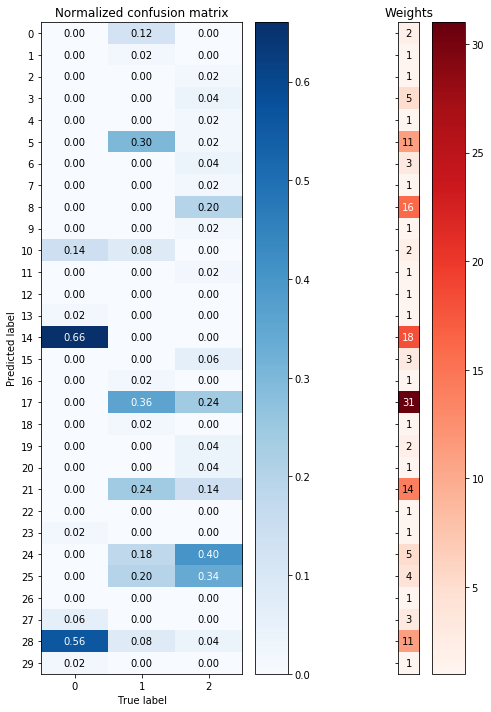

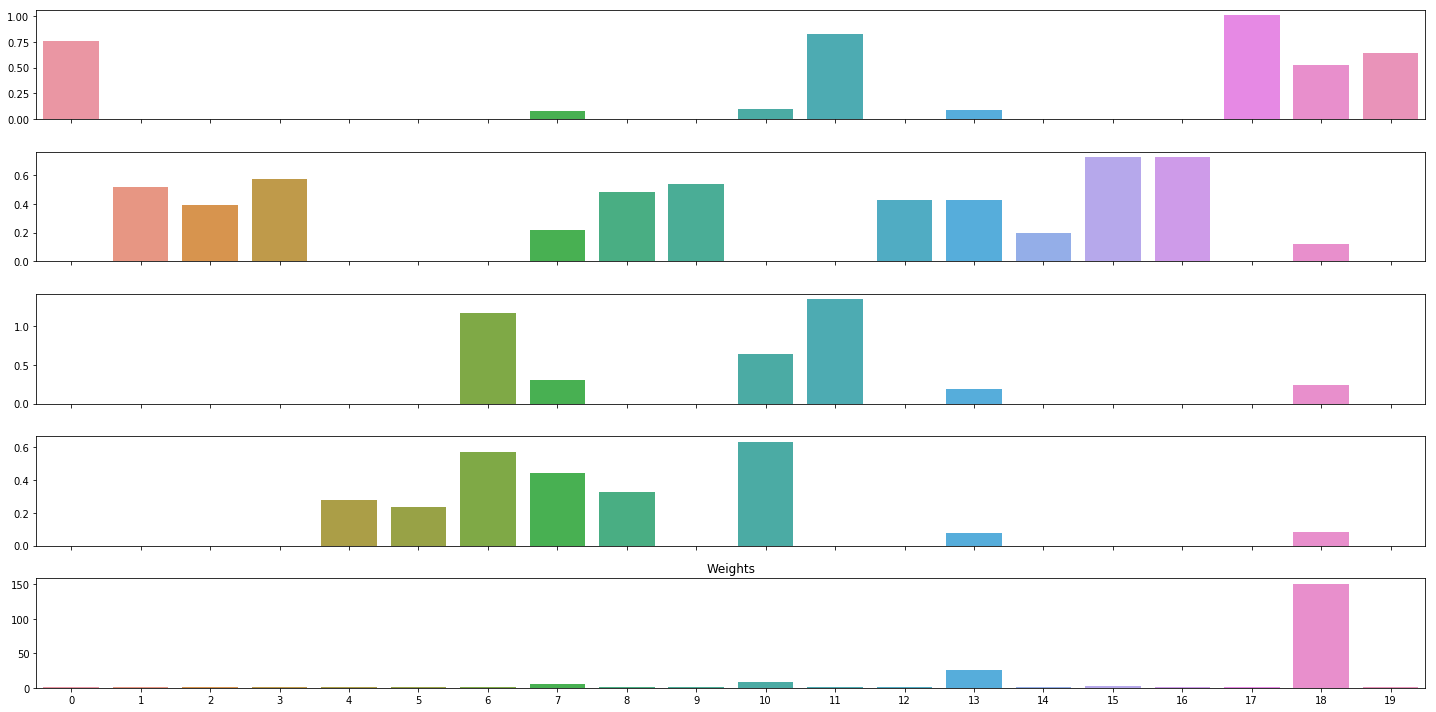

In [33]:
ca = ContrastAgent(cmemory_size=20,
                   eps=0.01,
                   maxi=1,
                   memory_size=30,
                   mini=1,
                   nb_closest=4,
                   nb_winners=2,
                   update_method=2)

NB_REPETITIONS = 5
SHUFFLE_DATA_ENABLED = 1
for i in range(NB_REPETITIONS):
    if SHUFFLE_DATA_ENABLED:
        shuffled_data = shuffle(new_data)
        ca.feed_data_online(shuffled_data, 1)
    else:
        ca.feed_data_online(new_data, 1)

def print_metrics(method="closest", nb_winners=4, tolerance=2.5, nb_print=20):
    """ 
    nb_winners only relevant for method "closest"
    tolerance only relevant for method "all"
    """
    ca.print_confusion_matrix(new_data, clusters_true2, method=method,
                              nb_winners=nb_winners, tolerance=tolerance)
    ca.print_contrasts(nb_print=nb_print)


PRINT_METRICS_DEFINED = True
print_metrics(method="closest", nb_winners=2)
# print_metrics(method="all", tolerance=2)

## Comparison to other algorithms

In [9]:
def print_matrix(predictions):
    class_names = np.array([str(i) for i in range(1+np.max(
        np.concatenate([clusters_true2, predictions])))])
    plot_confusion_matrix(
        clusters_true2, predictions, classes=class_names,
        normalize=True, title='Normalized confusion matrix',
        path=DATASET_PATH + DATASET_NAME)

### K-means

Normalized confusion matrix


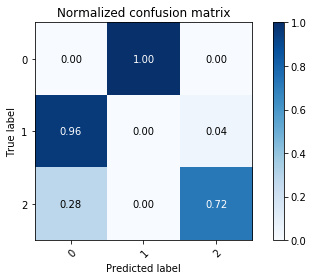

In [27]:
from sklearn.cluster import KMeans
kmeans_predictions = KMeans(n_clusters=nb_clusters_true).fit_predict(new_data)
print_matrix(kmeans_predictions)

Normalized confusion matrix


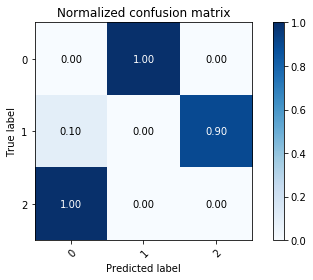

In [30]:
from sklearn.mixture import GaussianMixture
gmm_predictions = GaussianMixture(n_components=nb_clusters_true).fit_predict(new_data)
print_matrix(gmm_predictions)